In [1]:
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai import *
from fastai.data_block import _maybe_squeeze
from efficientnet_pytorch import EfficientNet

import pydicom
import os
import matplotlib.pyplot as plt
import collections
# from tqdm import tqdm_notebook as tqdm
# from datetime import datetime

from math import ceil, floor, log
import cv2


In [2]:
path = Path('/home/jupyter/rsns/data')
#df_train = pd.read_csv(path/'train_fastai_format.csv')

In [3]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

def _load_format(path, convert_mode, after_open)->Image:
    dcm = pydicom.dcmread(path)
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros((512,512,3))
    
    return Image(pil2tensor(img, np.float32))

vision.data.open_image = _load_format

# Radek's monkey patch to work out NAN in pandas
def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)

ItemList.label_from_df = modified_label_from_df

In [4]:
tfms = get_transforms(flip_vert=True,  max_warp=0., max_rotate=60., max_zoom=1.15)

In [9]:
data = (ImageList
        .from_csv(path,f'{path}/raw/train.csv',folder='/raw/stage_1_train_images')
        .split_by_rand_pct(seed=42)
        .label_from_df(label_delim=' ')
        .transform(tfms,size=(128,128))
        #.add_test(str(path) + '/preprocessed/128/test/' + test_fns)
        .databunch(bs=64,num_workers=8)
        .normalize(imagenet_stats)
       )

In [10]:
learn = cnn_learner(data,models.resnet18,metrics=[accuracy_thresh]).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.02E-02


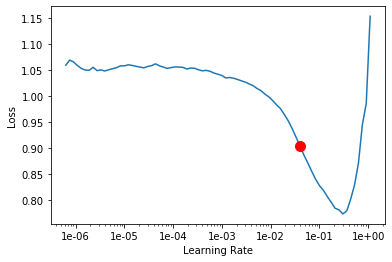

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
learn.fit_one_cycle(1,slice(1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time


KeyboardInterrupt: 